In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
from sklearn import svm, datasets
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
from IPython.display import HTML
import queue
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label

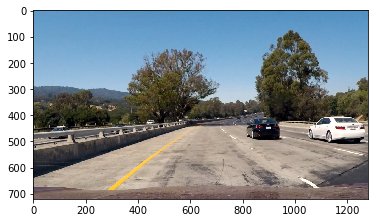

In [2]:
# Validate we can show an image
plt.imshow(mpimg.imread(os.path.join("test_images","test1.jpg")))

In [3]:
#get hog features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """Function that gets HOG features and  creates a visualization if requested"""
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features

In [4]:
#extract hog feature
def extract_hog_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """Function that extracts HOG features from an input set of images """
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [7]:
# Read in cars and notcars
car_images = glob.glob(os.path.join('vehicles/vehicles','*','*.png'))
notcar_images = glob.glob(os.path.join('non-vehicles/non-vehicles','*','*.png'))
cars = []
notcars = []
for c in car_images:
    cars.append(c)
for n in notcar_images:
    notcars.append(n)

print('Total Car images: ' + str(len(cars)))
print('Total Non-Car images: ' + str(len(notcars)))

Total Car images: 8792
Total Non-Car images: 8968


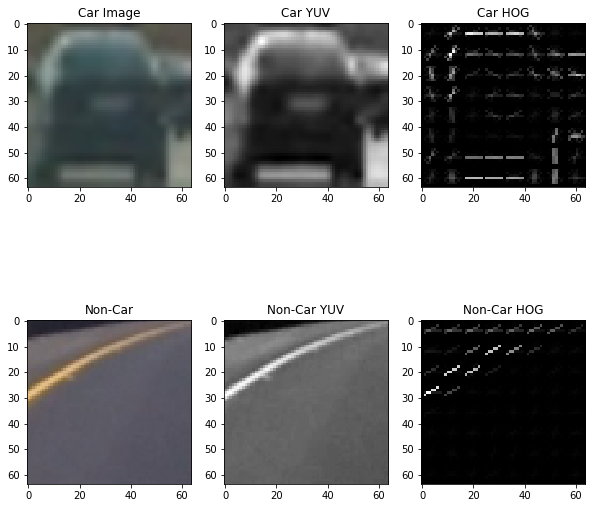

In [8]:
# vusualize images
rand_i = np.random.randint(0, 100)
car_img = mpimg.imread(car_images[rand_i])
converted_car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2YUV)[:,:,0]
feats, car_marked = get_hog_features(converted_car_img, 9, 8, 2, vis=True, feature_vec=True)
notcar_img = mpimg.imread(notcar_images[rand_i])
converted_not_car_img = cv2.cvtColor(notcar_img, cv2.COLOR_RGB2YUV)[:,:,0]
feats, notcar_marked = get_hog_features(converted_not_car_img, 9, 8, 2, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10,10))
ax1.imshow(car_img)
ax1.set_title('Car Image')
ax2.imshow(converted_car_img, cmap='gray')
ax2.set_title('Car YUV')
ax3.imshow(car_marked, cmap='gray')
ax3.set_title('Car HOG')
ax4.imshow(notcar_img)
ax4.set_title('Non-Car')
ax5.imshow(converted_not_car_img, cmap='gray')
ax5.set_title('Non-Car YUV')
ax6.imshow(notcar_marked, cmap='gray')
ax6.set_title('Non-Car HOG')

In [9]:
# extract feature sets and train a linear SVM classifier
def extract_train_and_test_sets(cars, notcars, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """Extracts training and test sets of HOG features given a 
        set of car and not car images, and HOG paramaters"""

    car_features = extract_hog_features(cars, color_space=color_space, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    notcar_features = extract_hog_features(notcars, color_space=color_space, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    return X_train, y_train, X_test, y_test, X_scaler
    
def linear_classify(X_train, y_train, X_test, y_test): 
    """Creates a linear SVM Classifierusing the input training and test sets 
        Return timing and accuracy data """
    # Train a Linear SVM Classifier
    clf = LinearSVC()
    t=time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    accuracy = clf.score(X_test, y_test)   
    
    #Return timing and accuracy
    return round(t2-t, 2), round(accuracy, 4)

In [10]:
#find optimal color space and hog channel
def optimize_color_channel(cars, notcars, color_spaces_list, hog_channel_list): 
    """Tests out a Linear SVM classifier on a combination of input 
        color spaces and HOG channels and returns a dictionary of results """
    results = {}
    for space in color_spaces_list:
        for chan in hog_channel_list:
            X_train, y_train, X_test, y_test, X_scaler = extract_train_and_test_sets(cars, notcars, 
                                                                           color_space=space, 
                                                                           hog_channel=chan)
            time, accuracy = linear_classify(X_train, y_train, X_test, y_test)
            
            identifier = space + ':' + str(chan)
            results[identifier] = accuracy
            print(identifier + ", Time=" + str(time) + " Accuracy=" + str(accuracy))
    
    return results

In [11]:
# List of Color spaces to try
spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

# List of Channels to try
hog_channel_list = [0,1,2,"ALL"]

results = optimize_color_channel(cars, notcars, spaces, hog_channel_list)

RGB:0, Time=10.49 Accuracy=0.9465
RGB:1, Time=9.31 Accuracy=0.9465
RGB:2, Time=10.85 Accuracy=0.9541
RGB:ALL, Time=27.43 Accuracy=0.9688
HSV:0, Time=19.94 Accuracy=0.9001
HSV:1, Time=27.24 Accuracy=0.9012
HSV:2, Time=10.32 Accuracy=0.9595
HSV:ALL, Time=7.44 Accuracy=0.9851
LUV:0, Time=10.03 Accuracy=0.9465
LUV:1, Time=19.73 Accuracy=0.9124
LUV:2, Time=27.17 Accuracy=0.897
LUV:ALL, Time=22.59 Accuracy=0.9783
HLS:0, Time=21.29 Accuracy=0.9046
HLS:1, Time=10.14 Accuracy=0.9474
HLS:2, Time=34.04 Accuracy=0.8843
HLS:ALL, Time=21.29 Accuracy=0.9817
YUV:0, Time=9.22 Accuracy=0.9474
YUV:1, Time=17.46 Accuracy=0.9133
YUV:2, Time=27.55 Accuracy=0.8986
YUV:ALL, Time=22.23 Accuracy=0.984
YCrCb:0, Time=10.98 Accuracy=0.9386
YCrCb:1, Time=22.98 Accuracy=0.9102
YCrCb:2, Time=23.85 Accuracy=0.8998
YCrCb:ALL, Time=20.33 Accuracy=0.982


In [13]:
print(results)

{'YCrCb:1': 0.91020000000000001, 'YUV:0': 0.94740000000000002, 'RGB:ALL': 0.96879999999999999, 'HSV:1': 0.9012, 'YCrCb:2': 0.89980000000000004, 'RGB:0': 0.94650000000000001, 'YUV:ALL': 0.98399999999999999, 'HLS:ALL': 0.98170000000000002, 'LUV:ALL': 0.97829999999999995, 'HLS:1': 0.94740000000000002, 'HLS:2': 0.88429999999999997, 'HSV:2': 0.95950000000000002, 'RGB:1': 0.94650000000000001, 'RGB:2': 0.95409999999999995, 'HSV:0': 0.90010000000000001, 'HSV:ALL': 0.98509999999999998, 'YCrCb:0': 0.93859999999999999, 'YUV:1': 0.9133, 'HLS:0': 0.90459999999999996, 'YUV:2': 0.89859999999999995, 'LUV:1': 0.91239999999999999, 'YCrCb:ALL': 0.98199999999999998, 'LUV:2': 0.89700000000000002, 'LUV:0': 0.94650000000000001}


In [20]:
print("########################################")
print("Color Space: HOG Channel |      Accuracy")
print("########################################")
for i in results.keys():           
    print("     %-9s           | %2.2f" % (i,results[i]*100)  + "%")       
print("########################################")

########################################
Color Space: HOG Channel |      Accuracy
########################################
     YCrCb:1             | 91.02%
     YUV:0               | 94.74%
     RGB:ALL             | 96.88%
     HSV:1               | 90.12%
     YCrCb:2             | 89.98%
     RGB:0               | 94.65%
     YUV:ALL             | 98.40%
     HLS:ALL             | 98.17%
     LUV:ALL             | 97.83%
     HLS:1               | 94.74%
     HLS:2               | 88.43%
     HSV:2               | 95.95%
     RGB:1               | 94.65%
     RGB:2               | 95.41%
     HSV:0               | 90.01%
     HSV:ALL             | 98.51%
     YCrCb:0             | 93.86%
     YUV:1               | 91.33%
     HLS:0               | 90.46%
     YUV:2               | 89.86%
     LUV:1               | 91.24%
     YCrCb:ALL           | 98.20%
     LUV:2               | 89.70%
     LUV:0               | 94.65%
########################################


In [19]:
#training the final classifier
chosen_cspace='YUV'
choose_hog_channel = 0
# Extract features using chosen color space and HOG channel
X_train, y_train, X_test, y_test, X_scaler = extract_train_and_test_sets(cars, notcars, 
                                                                         color_space=chosen_cspace,
                                                                         hog_channel=choose_hog_channel)

In [21]:
# Init classifier with tuned params
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)

# Train Classifier
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train classifier and chose params...')
# Check the score of the SVC
print('Test Accuracy of classifier = ', round(clf.score(X_test, y_test), 4))
print('Best params: ', clf.best_params_)

1178.9 Seconds to train classifier and chose params...
Test Accuracy of classifier =  0.9935
Best params:  {'kernel': 'rbf', 'C': 10}


In [22]:
#checkpoint store the classifier
data = {
    'clf': clf,
    'X_scaler': X_scaler,
    'chosen_cspace': chosen_cspace,
    'chosen_hog_chan': chosen_hog_chan
}
with open('clf_data.p', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [23]:
# load a pe-trained svc model 
dist_pickle = pickle.load( open("clf_data.p", "rb" ) )

# get attributes of our clf object
clf = dist_pickle["clf"]
X_scaler = dist_pickle["X_scaler"]
chosen_cspace = dist_pickle["chosen_cspace"]
chosen_hog_chan = dist_pickle["chosen_hog_chan"]

In [24]:
#gather varied test images
#get project vedio
clip = VideoFileClip("project_video.mp4")

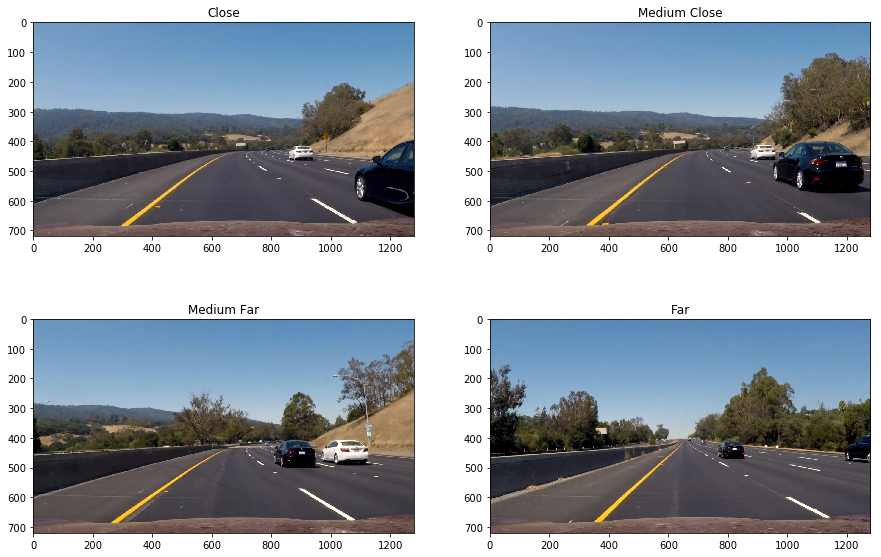

In [25]:
image_close = clip.get_frame(28)
image_mid_close = clip.get_frame(30)
image_mid_far = clip.get_frame(37)
image_far = clip.get_frame(50)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
ax1.imshow(image_close)
ax1.set_title('Close')
ax2.imshow(image_mid_close)
ax2.set_title('Medium Close')
ax3.imshow(image_mid_far)
ax3.set_title('Medium Far')
ax4.imshow(image_far)
ax4.set_title('Far')

In [27]:
#configure sliding window pipeline
def draw_boxes(img, ystart, ystop, scale, pix_per_cell=8, cell_per_block=2):
    """Function to draw a set of bounding boxes at a given scale"""
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]
    
    cv2.rectangle(draw_img,(0,ystart), (draw_img.shape[1],ystop),(0,0,255),9) 

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    cells_per_step = 8  # Instead of overlap, define how many cells to step.  Use 8 for the example
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
   
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            rect = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
            cv2.rectangle(draw_img,rect[0], rect[1],(255,0,0),3) 
                
    return draw_img

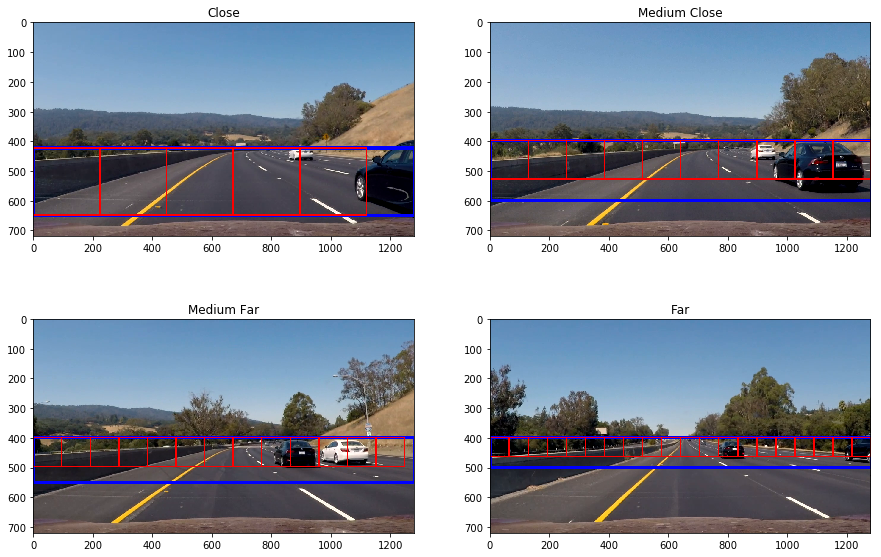

In [28]:
#apply search sizes and regions to images to tune window sizes
image_close_marked = draw_boxes(image_close, 425, 650, 3.5)
image_mid_close_marked = draw_boxes(image_mid_close, 400, 600, 2)
image_mid_far_marked = draw_boxes(image_mid_far, 400, 550, 1.5)
image_far_marked = draw_boxes(image_far, 400, 500, 1)


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
ax1.imshow(image_close_marked)
ax1.set_title('Close')
ax2.imshow(image_mid_close_marked)
ax2.set_title('Medium Close')
ax3.imshow(image_mid_far_marked)
ax3.set_title('Medium Far')
ax4.imshow(image_far_marked)
ax4.set_title('Far')

In [29]:
# define a function to find cars using sliding window and hog features
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient=9, pix_per_cell=8, 
              cell_per_block=2, cspace=chosen_cspace, hog_channel=chosen_hog_chan):
    """Extract features using HOG sub-sampling and make predictions using the given classifier"""
    cars_boxes = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image) 
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                test_features = X_scaler.transform(np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1))   
            else:
                test_features = X_scaler.transform(hog_feat1.reshape(1, -1))  

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rect = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                cars_boxes.append(rect)
    
    return cars_boxes

def sliding_window_pipe(img, svc, X_scaler):
    """Applys several sliding window passes of different sizes to a given image and returns all found windows"""
    hot_windows_close = find_cars(img, 425, 650, 3.5, svc, X_scaler)
    hot_windows_mid_close = find_cars(img, 400, 600, 2, svc, X_scaler) 
    hot_windows_mid_far = find_cars(img,  400, 550, 1.5, svc, X_scaler)
    hot_windows_far = find_cars(img, 400, 500, 1, svc, X_scaler)
    return hot_windows_close+hot_windows_mid_close+hot_windows_mid_far+hot_windows_far

def draw_boxes_on_image(img, rects):
    """Draws an input set of rectangles on an image"""
    result = np.copy(img)
    for rect in rects:
        cv2.rectangle(result,rect[0], rect[1],(0,0,255),4) 
    return result

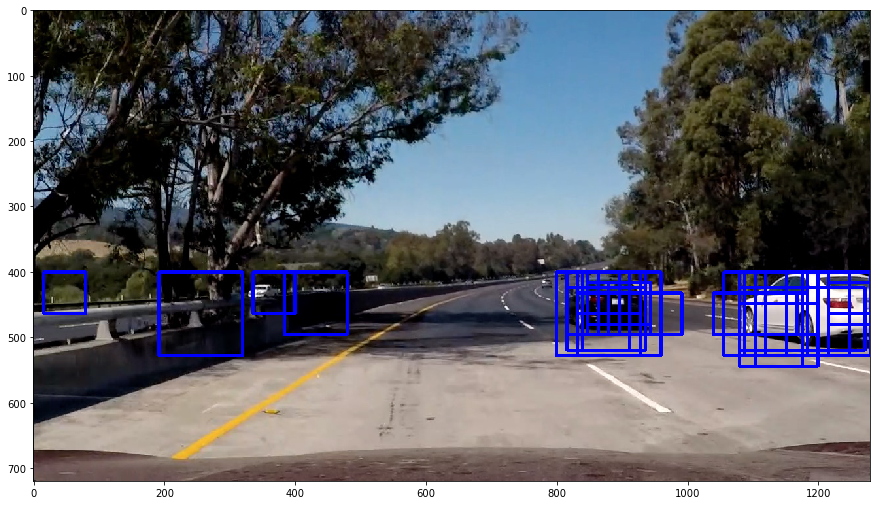

In [30]:
# Test the window pipeline on a test image
test_img = mpimg.imread(os.path.join("test_images","test5.jpg")) 
car_windows = sliding_window_pipe(test_img, clf, X_scaler)

# Draw the windows on the image
windows_image = draw_boxes_on_image(test_img, car_windows)
plt.figure(figsize=(15,15))
plt.imshow(windows_image)

In [31]:
#get heat map
def create_heat_map(img, box_list, threshold=1):
    """Creates a heatmap from a list of given boxes, and applys the 
       labeled heatmap to a given input image to draw bounding boxes"""
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1   
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0, 255)
    
    labels = label(heatmap)
       
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        
    return bboxes, heatmap

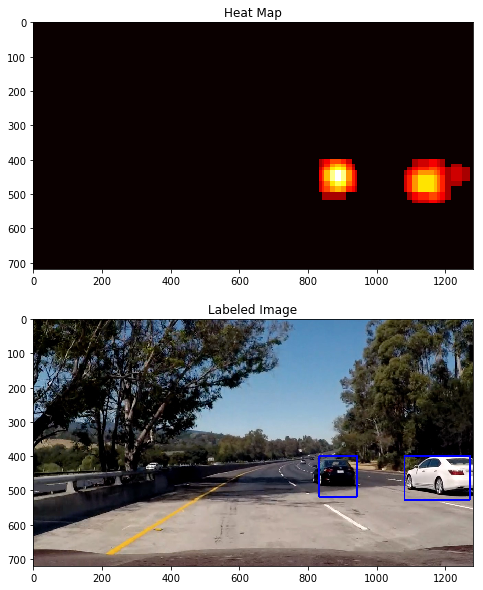

In [32]:
#test the heat map function
bboxes, heatmap = create_heat_map(test_img, car_windows, threshold=3)

f, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(15,10))
ax1.imshow(heatmap, cmap='hot')
ax1.set_title('Heat Map')
ax2.imshow(draw_boxes_on_image(test_img, bboxes))
ax2.set_title('Labeled Image')

In [33]:
#Combine all the previous steps into a processing pipe that can be used with the moviepy video processing.
def process_image(image):
    """Detects vehicles on a given image and adds a bounding box around each one"""    
    
    # Find bounding boxes
    car_windows = sliding_window_pipe(image, clf, X_scaler)
    full_detections = draw_boxes_on_image(image, car_windows)
    
    #Create heatmap and apply to image
    bboxes, heatmap = create_heat_map(image, car_windows, threshold=3)
    
    # Draw bounding boxes
    result = draw_boxes_on_image(image, bboxes)
    
    # Add composities of heatmap and sliding window images
    full_detections_small = cv2.resize(full_detections, (int(full_detections.shape[1]/4),int(full_detections.shape[0]/4)))
    heatmap_small = cv2.resize(heatmap, (int(heatmap.shape[1]/4),int(heatmap.shape[0]/4)))
    color_heatmap = np.dstack(( heatmap_small, heatmap_small, heatmap_small)) * 255
    
    result[:full_detections_small.shape[0],-full_detections_small.shape[1]:,:] = full_detections_small
    result[:color_heatmap.shape[0],-color_heatmap.shape[1]-full_detections_small.shape[1]:-full_detections_small.shape[1],:] = color_heatmap
    
    # Add detection text    
    cv2.putText(result,"Total Cars Detected: %d" % len(bboxes), (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
        
    return result

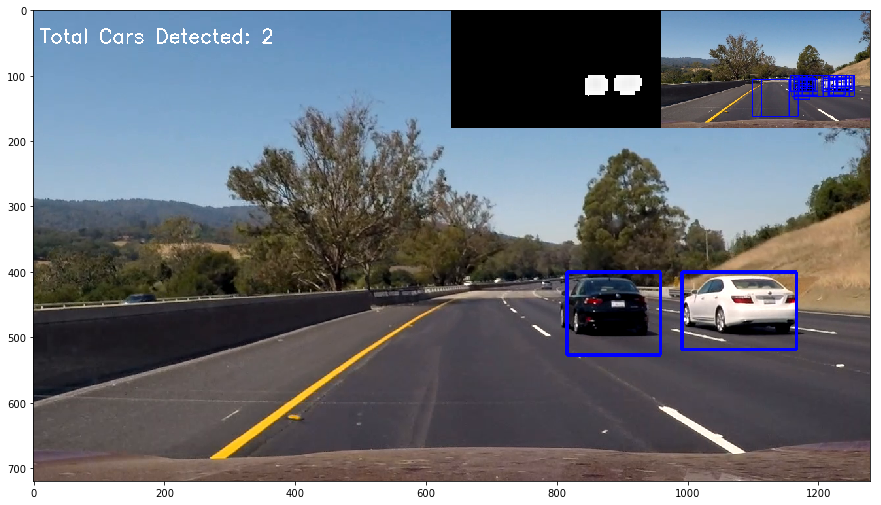

In [34]:
# Test the pipeline on a single frame of the project video to verify it works all together
clip = VideoFileClip("project_video.mp4")
plt.figure(figsize=(15,15))
plt.imshow(process_image(clip.get_frame(38)))
clip.reader.close()
clip.audio.reader.close_proc()

In [35]:
# Process the project video using the pipeline
output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
proc_clip = clip1.fl_image(process_image) 
%time proc_clip.write_videofile(output, audio=False)

# Close the video to avoid open handles
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [02:28<00:03,  3.92s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 2min 31s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [37]:
output2 = 'project_video_output.mp4'
clip2 = VideoFileClip("project_video.mp4")
proc_clip2 = clip2.fl_image(process_image) 
%time proc_clip2.write_videofile(output2, audio=False)
clip2.reader.close()
clip2.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [21:30:26<01:01, 61.45s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 21h 30min 28s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

In [39]:
output6 = 'my_self_video_output.mp4'
clip6 = VideoFileClip("my_self_vedio.mp4")
proc_clip6 = clip6.fl_image(process_image) 
%time proc_clip6.write_videofile(output6, audio=False)
clip6.reader.close()
clip6.audio.reader.close_proc()

[MoviePy] >>>> Building video my_self_video_output.mp4
[MoviePy] Writing video my_self_video_output.mp4


100%|█████████▉| 1260/1261 [22:15:30<01:03, 63.60s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_self_video_output.mp4 

Wall time: 22h 15min 35s


AttributeError: 'NoneType' object has no attribute 'reader'

In [40]:
#improved pipeline
# Size of history
size_of_history = 15

# global lane lines
boxes_q = queue.Queue(maxsize=size_of_history)

def resetPipe():
    """Reset Pipeline"""
    global boxes_q    
    boxes_q = queue.Queue(maxsize=size_of_history)

def process_image_improved(image):
    """Combine all previous steps into a single image processing pipe to be used to process videos"""    
    
    global boxes_q 
    
    # Find bounding boxes
    car_windows = sliding_window_pipe(image, clf, X_scaler)
    full_detections = draw_boxes_on_image(image, car_windows)
    
    #Create heatmap and apply to image
    bboxes_frame, heatmap = create_heat_map(image, car_windows, threshold=3)
        
    if boxes_q.full():
        boxes_q.get()
    
    if len(bboxes_frame) > 0:
        boxes_q.put(bboxes_frame) 
    
    # Calculate full array and threshold based on amount of previous boxes
    frame_history = boxes_q.qsize()
    threshold = max(frame_history - 5,0)
    bboxes_full_array = []
    for frame in list(boxes_q.queue):
        bboxes_full_array += frame
        
    #Create heatmap and apply to image
    bboxes, heatmap_combo = create_heat_map(image, bboxes_full_array, threshold=threshold)
    
    # Draw bounding boxes
    result = draw_boxes_on_image(image, bboxes)
    
    # Add composities of heatmap and sliding window images
    full_detections_small = cv2.resize(full_detections, (int(full_detections.shape[1]/4),int(full_detections.shape[0]/4)))
    heatmap_small = cv2.resize(heatmap, (int(heatmap.shape[1]/4),int(heatmap.shape[0]/4)))
    color_heatmap = np.dstack(( heatmap_small, heatmap_small, heatmap_small)) * 255
    
    result[:full_detections_small.shape[0],-full_detections_small.shape[1]:,:] = full_detections_small
    result[:color_heatmap.shape[0],-color_heatmap.shape[1]-full_detections_small.shape[1]:-full_detections_small.shape[1],:] = color_heatmap
    
    # Add detection text    
    cv2.putText(result,"Total Cars Detected: %d" % len(bboxes), (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
        
    return result

In [41]:
resetPipe()

output3 = 'improve_test_video_output.mp4'
clip3 = VideoFileClip("test_video.mp4")
proc_clip3 = clip3.fl_image(process_image_improved) 
%time proc_clip3.write_videofile(output3, audio=False)
clip3.reader.close()
clip3.audio.reader.close_proc()

[MoviePy] >>>> Building video improve_test_video_output.mp4
[MoviePy] Writing video improve_test_video_output.mp4


 97%|█████████▋| 38/39 [02:39<00:04,  4.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: improve_test_video_output.mp4 

Wall time: 2min 42s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output3))

In [42]:
resetPipe()
output4 = 'improve_project_video_output.mp4'
clip4 = VideoFileClip("project_video.mp4")
proc_clip4 = clip4.fl_image(process_image_improved) 
%time proc_clip4.write_videofile(output4, audio=False)
clip4.reader.close()
clip4.audio.reader.close_proc()

[MoviePy] >>>> Building video improve_test_video_output.mp4
[MoviePy] Writing video improve_test_video_output.mp4


100%|█████████▉| 1260/1261 [24:00:52<01:08, 68.61s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: improve_test_video_output.mp4 

Wall time: 1d 55s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output4))

In [43]:
resetPipe()
output5 = 'improve_my_self_video_output.mp4'
clip5 = VideoFileClip("my_self_vedio.mp4")
proc_clip5 = clip5.fl_image(process_image_improved) 
%time proc_clip5.write_videofile(output5, audio=False)
clip5.reader.close()
clip5.audio.reader.close_proc()

[MoviePy] >>>> Building video improve_my_self_video_output.mp4
[MoviePy] Writing video improve_my_self_video_output.mp4


100%|█████████▉| 1260/1261 [26:48:17<01:16, 76.59s/it]   


[MoviePy] Done.
[MoviePy] >>>> Video ready: improve_my_self_video_output.mp4 

Wall time: 1d 2h 48min 20s


AttributeError: 'NoneType' object has no attribute 'reader'